Reloading modules sometimes causes errors. It's easier to just restart the notebook kernel and run from the start every time.

## Setup environment

In [1]:
checkpoint_dir="checkpoints"
if 'google.colab' in str(get_ipython()): #type: ignore
    COLAB = True
    print('Running on colab')
    %cd /content/
    !git clone https://github.com/TeamDman/Vehicular-Game-Theory
    %cd /content/Vehicular-Game-Theory/platoongame
    !git pull

    from utils import get_device
    import torch
    assert get_device() == torch.device("cuda")

    use_gdrive_checkpoints = True #@param {type:"boolean"}
    if use_gdrive_checkpoints:
        from google.colab import drive #type: ignore
        drive.mount('/content/drive')

        !mkdir -p /content/drive/MyDrive/checkpoints
        checkpoints_dir = "/content/drive/MyDrive/checkpoints"
else:
    COLAB = False
    print('Not running on colab')

Not running on colab


## Configuration

### Seed RNG

In [2]:
import random
random_seed = 42 #@param {type:"integer"}
random.seed(random_seed)
import torch
torch.manual_seed(random_seed)

### Vehicle provider config

In [3]:
from vehicles import JsonVehicleProvider, RandomVehicleProvider, RubbishVehicleProvider


provider = "random" #@param ["random", "json", "rubbish"]
if provider == "json":
  vehicle_provider = JsonVehicleProvider("../subgame/python/solutions.json")
elif provider == "random":
  vehicle_provider=RandomVehicleProvider(
    # this affects model shape
    num_max_vulns=7 #@param {type:"integer"}
    ,
    prob_mu=0.5 #@param {type:"number"}
    ,
    prob_sigma=0.25 #@param {type:"number"}
    ,
    sev_mu=2 #@param {type:"number"}
    ,
    sev_sigma=1 #@param {type:"number"}
    ,
  )
elif provider == "rubbish":
  vehicle_provider=RubbishVehicleProvider()
else:
  raise ValueError("unknown provider chosen")

In [4]:
from pprint import pprint
import dataclasses
pprint(dataclasses.asdict(vehicle_provider.next()))

{'in_platoon': False,
 'risk': 2.3366904258728027,
 'vulnerabilities': ({'prob': 0.5841726064682007,
                      'severity': 2,
                      'state': <CompromiseState.NOT_COMPROMISED: 1>},)}


### Game config

In [5]:
from game import GameConfig

game_config=GameConfig(
    max_vehicles=10 #@param {type:"integer"}
    ,
    cycle_enabled=False #@param {type:"boolean"}
    ,
    cycle_every=5 #@param {type:"integer"}
    ,
    cycle_allow_platoon=False #@param {type:"boolean"}
    ,
    cycle_num=3 #@param {type:"integer"}
)

### Attacker agent config

In [6]:
from agents import AttackerAgent, PassiveAgent, BasicAttackerAgent
from game import State
from vehicles import CompromiseState

attacker_ = "humanish" #@param ["passive", "humanish"]
if attacker_ == "passive":
  attacker = PassiveAgent()
elif attacker_ == "humanish":
  def get_attacker_utility(self:AttackerAgent, state: State) -> float:
    members = [vehicle for vehicle in state.vehicles if vehicle.in_platoon]
    comp = [1 for v in members if any([True if vuln.state != CompromiseState.NOT_COMPROMISED else False for vuln in v.vulnerabilities])]
    return len(comp)

  attacker = BasicAttackerAgent(
    attack_limit=1 #@param {type:"integer"}
    ,
    attack_interval=5 #@param {type:"integer"},
    ,
    utility_func=get_attacker_utility
  )
else:
  raise ValueError("unknown attacker chosen")

### Defender agent config

In [7]:
from agents import WolpertingerDefenderAgent
from models import StateShapeData
from vehicles import Vehicle, Vulnerability

def get_defender_utility(self:WolpertingerDefenderAgent, state: State) -> float:
    members = [vehicle for vehicle in state.vehicles if vehicle.in_platoon]
    comp = [1 for v in members for vuln in v.vulnerabilities if vuln.state != CompromiseState.NOT_COMPROMISED]
    if len(comp) > 0: return 0
    return len(members)

load_checkpoint = False #@param {type:"boolean"}
defender=WolpertingerDefenderAgent(
    state_shape_data=StateShapeData(
        num_vehicles=game_config.max_vehicles,
        num_vehicle_features=Vehicle.get_shape()[0],
        num_vulns=vehicle_provider.max_vulns,
        num_vuln_features=Vulnerability.get_shape()[0]
    ),
    learning_rate=0.001 #@param {type:"number"}
    ,
    num_proposals=100 #@param {type: "integer"}
    ,
    utility_func=get_defender_utility
    ,
    ou_theta = 0.0 #@param {type: "number"}
    ,
    ou_mu = 0.0 #@param {type: "number"}
    ,
    ou_sigma = 3 #@param {type: "number"}
    ,
    epsilon_decay_time=50000 #@param {type: "integer"}
)

if load_checkpoint:
  defender.load(
    dir=checkpoints_dir,
    prefix="2022-10-13 2258-27 054659" #@param {type: "string"}
)

c:\Users\TeamD\.conda\envs\subgame\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


## Baseline evaluation

untrained defender


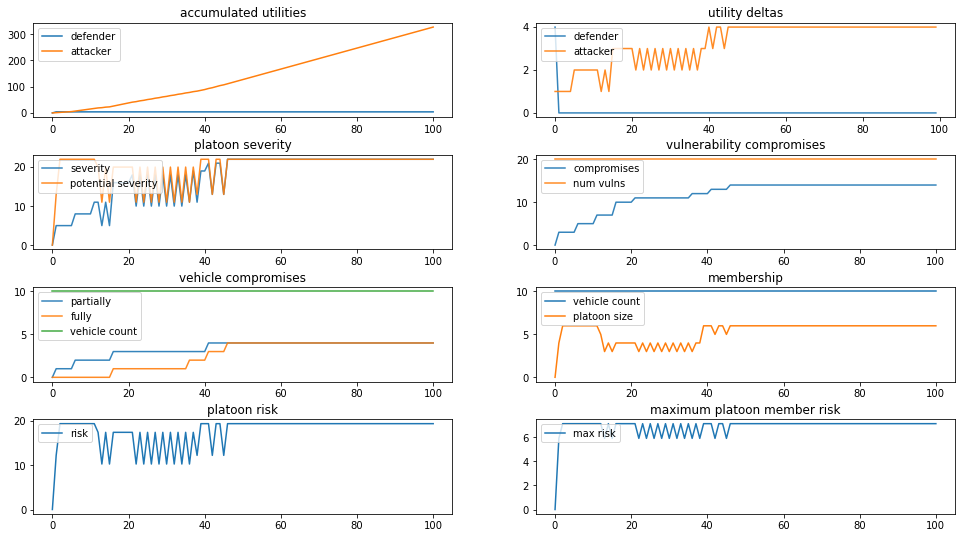

In [8]:
from agents import RandomDefenderAgent
from evaluation import get_episode_metrics

print("untrained defender")
get_episode_metrics(
    defender_agent=defender,
    attacker_agent=attacker,
    game_config=game_config,
    vehicle_provider=vehicle_provider,
    num_turns=100 #@param {type:"integer"}
).plot()

random defender


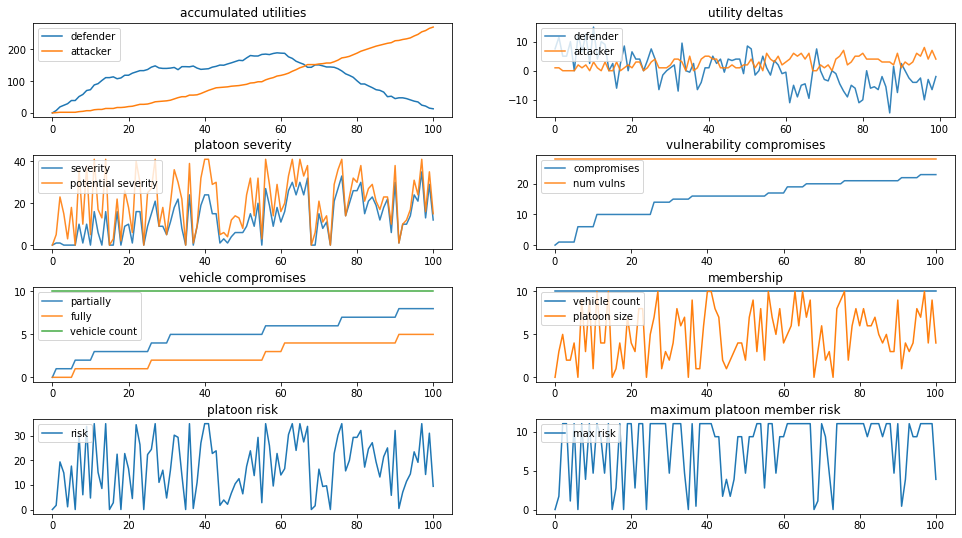

In [9]:
print("random defender")
get_episode_metrics(
    defender_agent=RandomDefenderAgent(),
    attacker_agent=attacker,
    game_config=game_config,
    vehicle_provider=vehicle_provider,
    num_turns=100 #@param {type:"integer"}
).plot()

## Training

### Replay memory config

In [10]:
from memory import DequeReplayMemory

memory = DequeReplayMemory(
    capacity=100000 #@param {type:"integer"}
)

### Training metrics tracker config

In [11]:
from metrics import TrainingMetricsTracker
tracker = TrainingMetricsTracker()

### Trainer config

In [27]:
from training import WolpertingerDefenderAgentTrainer, WolpertingerDefenderAgentTrainerConfig
trainer = WolpertingerDefenderAgentTrainer(WolpertingerDefenderAgentTrainerConfig(
    game_config=game_config,
    vehicle_provider=vehicle_provider,
    attacker_agent=attacker,
    defender_agent=defender,
    checkpoint_interval=-1 #@param {type:"integer"}
    ,
    memory=memory,
    metrics_tracker=tracker,
    batch_size=50 #@param {type:"integer"}
    ,
    train_steps=25000 #@param {type:"integer"}
    ,
    exploration_per_step=5 #@param {type:"integer"}
    ,
    warmup_replay=2000 #@param {type:"integer"}
    ,
    max_steps_per_episode=5 #@param {type:"integer"}
    ,
    attacker_headstart=3 #@param {type:"integer"}
    ,
    update_policy_interval=1 #@param {type:"integer"}
    ,
    policy_update_type="soft" #@param ["soft", "hard"]
    ,
    reward_gamma = 0.99 #@param {type:"number"}
    ,
    soft_update_tau = 0.001 #@param {type:"number"}
))

In [13]:
trainer.warmup()

Warming up...


  0%|          | 0/2000 [00:00<?, ?it/s]

Warmup complete~!


In [14]:
# arbitrary number, but we need to be sure there are enough transitions that have rewards
# lost a lot of time debugging because of this
reward_expectation=100 #@param {type:"integer"}
reward_expectation_steps = 1000 #@param {type:"integer"}
assert sum([e.reward for e in memory.sample(min(reward_expectation_steps, len(memory)))]) > reward_expectation

(array([617.,  87.,  82.,  44.,  45.,  35.,  20.,  32.,  18.,  20.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

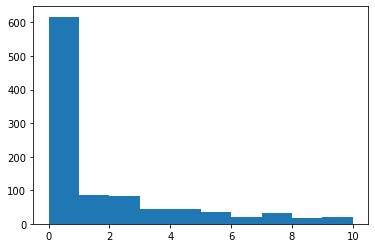

In [17]:
import matplotlib.pyplot as plt
rewards = [float(x.reward) for x in memory.sample(1000)]
plt.hist(rewards)

In [18]:
# ensure that there are many more non-zero rewards than zero rewards
for _ in range(5):
    for x in memory.sample(len(memory)):
        if x.reward > 0:
            memory.push(x)

(array([ 823., 1919., 1644., 1190., 1110.,  921.,  768.,  775.,  402.,
         448.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

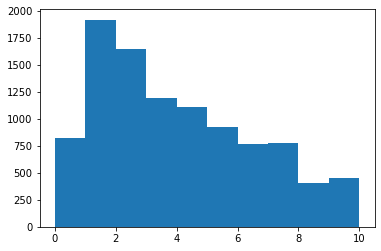

In [28]:
rewards = [float(x.reward) for x in memory.sample(10000)]
plt.hist(rewards)

(array([198.,  69., 174., 239., 160.,  90.,  45.,  12.,  12.,   1.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

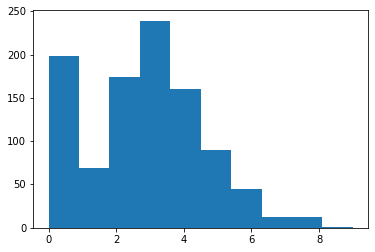

In [20]:
check_vulns = 1000
comps = [
    x.state.vulnerabilities[:,:,:,3].sum().item()
    for x in memory.sample(check_vulns)
]
plt.hist(comps)

### Perform training

In [29]:
trainer.train()

Warming up...


0it [00:00, ?it/s]

Warmup complete~!


  0%|          | 0/25000 [00:00<?, ?it/s]

train step 00000 reward={max=05.0000, min=00.0000, mean=01.0000} optimizing loss=02.8699 diff={max=08.5913, min=00.0084, mean=00.9613} policy_loss=-3.4054 policy updated! 
train step 00001 reward={max=05.0000, min=00.0000, mean=03.0000} optimizing loss=02.5384 diff={max=05.0730, min=00.0069, mean=01.1664} policy_loss=-3.0309 policy updated! 
train step 00002 reward={max=00.0000, min=00.0000, mean=00.0000} optimizing loss=02.9350 diff={max=04.8879, min=00.0035, mean=01.2698} policy_loss=-2.6268 policy updated! 
train step 00003 reward={max=05.0000, min=00.0000, mean=02.0000} optimizing loss=02.4284 diff={max=03.8181, min=00.0129, mean=01.2506} policy_loss=-2.8286 policy updated! 
train step 00004 reward={max=00.0000, min=00.0000, mean=00.0000} optimizing loss=01.9027 diff={max=05.5460, min=00.0304, mean=01.0349} policy_loss=-3.0869 policy updated! 
train step 00005 reward={max=05.0000, min=00.0000, mean=01.0000} optimizing loss=02.4596 diff={max=04.5492, min=00.0028, mean=01.2193} polic

KeyboardInterrupt: 

In [ ]:
# todo: predict a distribution instead of single actions if attacker behaviour is nondeterministic

In [22]:
attempt_gpu_mem_flush = False #@param {type:"boolean"}
if attempt_gpu_mem_flush:
    import torch
    torch.cuda.empty_cache()
    import gc
    gc.collect()
    print(torch.cuda.memory_summary(device=None, abbreviated=False))

### View training metrics

No stats to plot below loss threshold 1


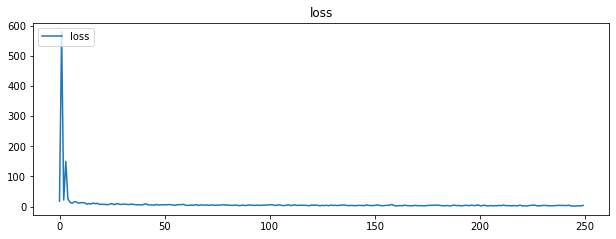

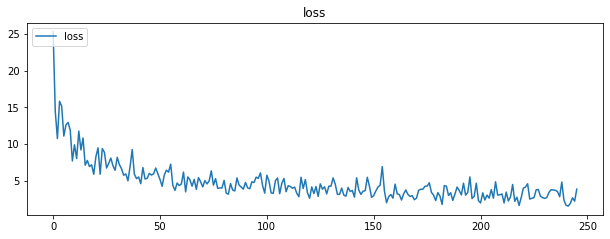

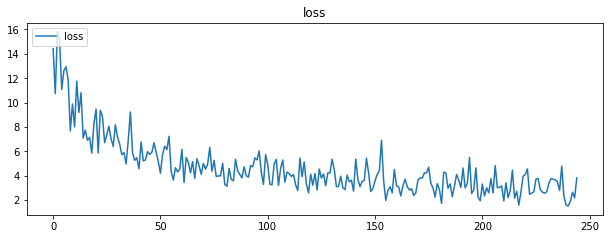

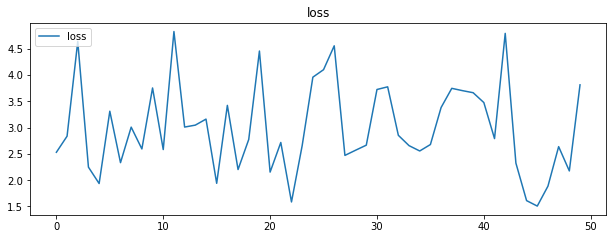

In [23]:
tracker.plot()
tracker.plot(loss_threshold=100)
tracker.plot(loss_threshold=20)
tracker.plot(loss_threshold=5)
tracker.plot(loss_threshold=1)

## Evaluation

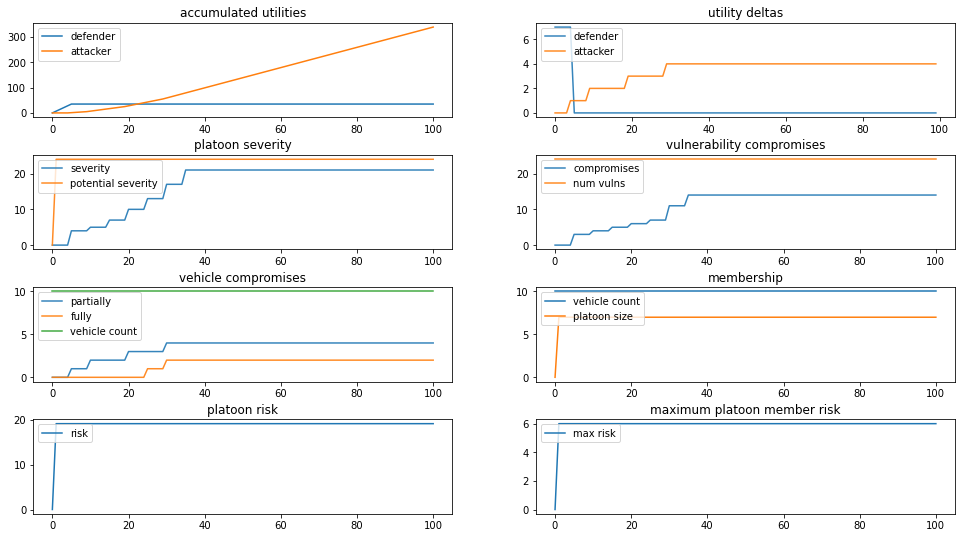

In [24]:
get_episode_metrics(
    defender_agent=defender,
    attacker_agent=attacker,
    game_config=game_config,
    vehicle_provider=vehicle_provider,
    num_turns=100 #@param {type:"integer"}
).plot()

In [25]:
from evaluation import sample_model_outputs
sample_model_outputs(
    defender_agent=defender,
    memory=memory,
)

action.members tensor([-10., -10.,  10.,  10.,  10.,  10.,  10.,  10.,  10., -10.],
       grad_fn=<SumBackward1>)
q_pred tensor([4.1732, 1.7117, 4.2848, 3.5527, 2.1747, 5.3937, 3.7552, 4.2848, 3.5265,
        3.0028], grad_fn=<ReshapeAliasBackward0>)
batch.reward tensor([4., 2., 7., 3., 5., 5., 7., 7., 4., 1.])
pred reward err tensor([ 0.1732, -0.2883, -2.7152,  0.5527, -2.8253,  0.3937, -3.2448, -2.7152,
        -0.4735,  2.0028], grad_fn=<SubBackward0>)


## Manually checkpoint model

In [31]:
from utils import get_prefix

manual_checkpoint = False #@param {type:"boolean"}
if manual_checkpoint:
    prefix = get_prefix()
    defender.save(dir=checkpoints_dir, prefix=prefix)
    trainer.config.dump(dir=checkpoints_dir, prefix=prefix)
    print(prefix)

2022-10-23 0015-31 350720
